<a href="https://colab.research.google.com/github/Quantyca/demo-ateam-dl/blob/master/image-classification/protein-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein: training


##  Intro

**Problem type:** Multi-label prediction with Human Protein Atlas Image Dataset

**Dataset:** [Human Protein Atlas Image Classification from Kaggle](https://www.kaggle.com/c/human-protein-atlas-image-classification)

## Import libs

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
!pip list | grep fastai

fastai                   1.0.42               


In [0]:
from fastai import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [0]:
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.42
fastprogress  : 0.1.19
torch         : 1.0.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Wed Feb 13 11:07:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+-------

## Set environment

In [0]:
! mkdir -p /root/.fastai/models
! mkdir -p /root/.fastai/data
! ln -s /root/.fastai/models /content
! ln -s /root/.fastai/data /content
! rm -rf /content/sample_data/
#! mkdir data models

ln: failed to create symbolic link '/content/models': File exists
ln: failed to create symbolic link '/content/data': File exists


In [0]:
!pwd && ls -l

/content
total 8
lrwxrwxrwx 1 root root   18 Feb 13 09:17 data -> /root/.fastai/data
drwx------ 4 root root 4096 Feb 13 09:48 gdrive
lrwxrwxrwx 1 root root   20 Feb 13 09:17 models -> /root/.fastai/models
drwxr-xr-x 4 root root 4096 Feb 13 09:17 protein


In [0]:
PROJECT_NAME = 'protein'

In [0]:
PATH = Path(PROJECT_NAME)
DATA_PATH = Path(PATH/'data')
MODEL_PATH = Path(PATH/'models')

In [0]:
if DATA_PATH.exists() == False: DATA_PATH.mkdir(parents=True, exist_ok=True)
if MODEL_PATH.exists() == False: MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [0]:
! ls -l {PATH}

total 8
drwxr-xr-x 4 root root 4096 Feb 13 09:24 data
drwxr-xr-x 2 root root 4096 Feb 13 09:17 models


In [0]:
np.random.seed(42)

## Getting the data

Let's download the datset from kaggle ...

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Now we can upload the kaggle.json file on colab

In [0]:
if Path('/root/.kaggle/kaggle.json').exists() == False:
  print('Downloading kaggle.json')
  kaggle_folder = Path.home()/'.kaggle'
  kaggle_folder.mkdir(parents=True, exist_ok=True)
  kaggle_file = kaggle_folder/'kaggle.json'
  _=download_url('https://storage.googleapis.com/ml_quantyca_it/andrea/kaggle.json', kaggle_file, overwrite=False)
  kaggle_file.chmod(600)
  

In [0]:
! ls  -l  /root/.kaggle/

total 4
---x-wx--T 1 root root 63 Feb 13 09:17 kaggle.json


You're all set to download the data from [Human Protein Atlas Image Classification Competition](https://www.kaggle.com/c/human-protein-atlas-image-classification). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

### Train data

In [0]:
if Path(DATA_PATH/'train.zip').exists() == False : 
  ! kaggle competitions download -c human-protein-atlas-image-classification -f train.zip -p {DATA_PATH}  
  
if Path(DATA_PATH/'train.csv').exists() == False : 
  ! kaggle competitions download -c human-protein-atlas-image-classification -f train.csv -p {DATA_PATH}  

In [0]:
TRAIN_PATH = DATA_PATH/'train'

In [0]:
if Path(TRAIN_PATH).exists() == False : 
  ! unzip -q -n {DATA_PATH}/train.zip -d {TRAIN_PATH}

In [0]:
! ls  {TRAIN_PATH} | head

00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png


### Test Data

In [0]:
if Path(DATA_PATH/'test.zip').exists() == False :
  ! kaggle competitions download -c human-protein-atlas-image-classification -f test.zip -p {DATA_PATH} 
if Path(DATA_PATH/'sample_submission.csv').exists() == False :
  ! kaggle competitions download -c human-protein-atlas-image-classification -f sample_submission.csv -p {DATA_PATH} 

In [0]:
TEST_PATH = DATA_PATH/'test'

In [0]:
if Path(TEST_PATH).exists() == False : 
  ! unzip -q -n {DATA_PATH}/test.zip -d {TEST_PATH}

In [0]:
! ls  {TEST_PATH} | head

00008af0-bad0-11e8-b2b8-ac1f6b6435d0_blue.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_green.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_red.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_yellow.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_blue.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_green.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_red.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_yellow.png
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0_blue.png
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0_green.png


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Explore data

In [0]:
import cv2

In [0]:
# adapted from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
def open_4_channel(fname):
    fname = str(fname)
    #print("open: ", fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32).float())

In [0]:
def show_img(im, figsize=None, ax=None, title=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if title:  ax.set_title(title)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  
def show_image_by_channels(path, id) :
  fig, axes = plt.subplots(2, 2, figsize=(12, 12))
  for i, ax in enumerate(axes.flat):
      filters = ['green', 'red', 'blue', 'yellow']
      #img = open_image(path/f'{id}_{filters[i]}.png')
      file_name = str(path/f'{id}_{filters[i]}.png')
      img = cv2.imread(file_name)
      show_img(img, ax=ax, title=f'filter: {filters[i]}')
  plt.show()

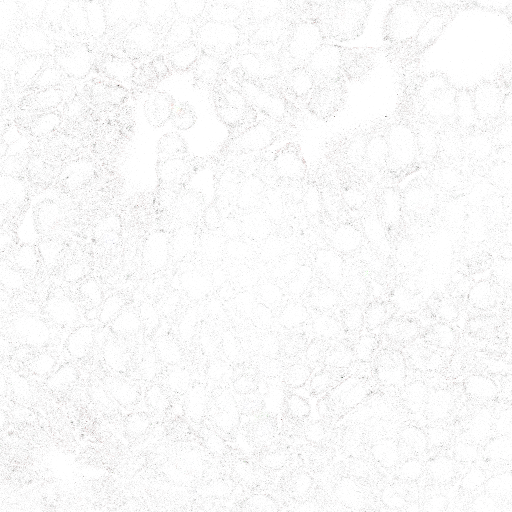

In [0]:
open_4_channel(TRAIN_PATH/'00070df0-bbc3-11e8-b2bc-ac1f6b6435d0')

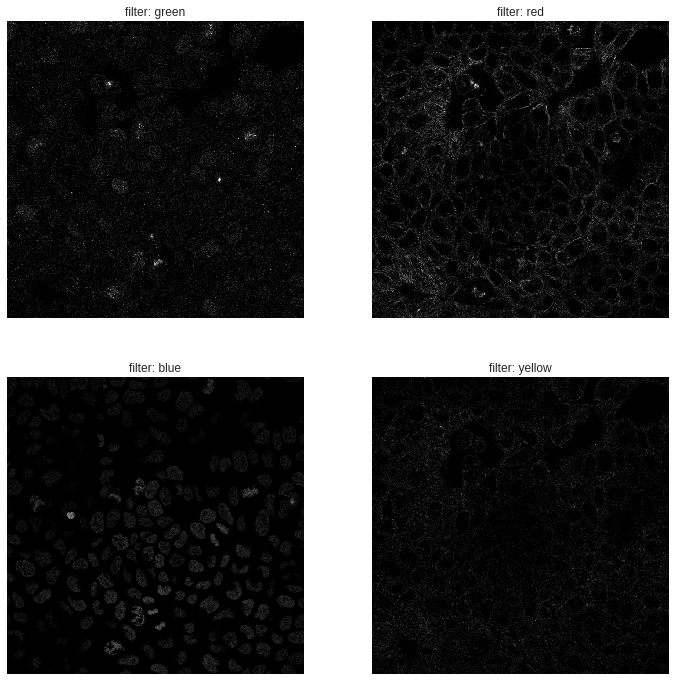

In [0]:
show_image_by_channels(TRAIN_PATH, '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0')

## Prepare data for training

See this [kernel ](https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039?)

In [0]:
src = (ImageItemList.from_csv(DATA_PATH, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.38)
       .label_from_df(label_delim=' ',  classes=[str(i) for i in range(28)]))

In [0]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [0]:

src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [0]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(TEST_PATH)}))
test_ids[:5]

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']

In [0]:
test_fnames = [TEST_PATH/test_id for test_id in test_ids]
test_fnames[:5]

[PosixPath('protein/data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('protein/data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('protein/data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('protein/data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('protein/data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

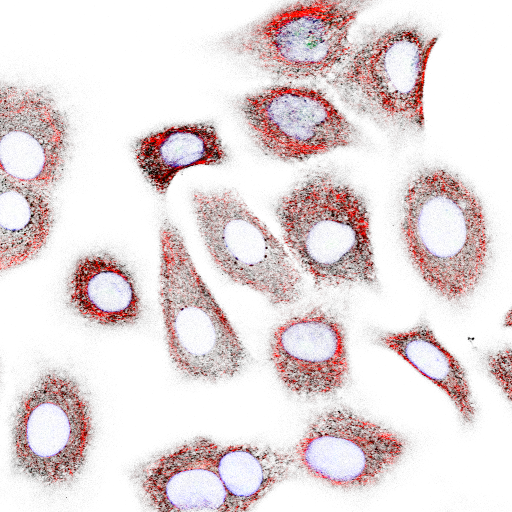

In [0]:
img = open_4_channel(TEST_PATH/'00008af0-bad0-11e8-b2b8-ac1f6b6435d0')
img

In [0]:
#src.add_test(test_fnames, label='0')

In [0]:
# src.test.x.create_func = open_4_channel
# src.test.x.open = open_4_channel

## Define architecture

In [0]:
import torch
import torch.nn as nn
import torchvision


RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [0]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [0]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

## Training stage 1

In [0]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
#stats = imagenet_stats
stats = protein_stats

In [0]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)
#trn_tfms,_ = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
size = 256
#size = 128

In [0]:
#data = (src.transform((trn_tfms, _), size=size).databunch().normalize(stats))

data = (src.transform(tfms, size=size).databunch().normalize(stats))

In [0]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (19265 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 18, MultiCategory 0]...
Path: protein/data
x: ImageItemList (19265 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: protein/data;

Valid: LabelList
y: MultiCategoryList (11807 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: protein/data
x: ImageItemList (11807 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: protein/data;

Test: None

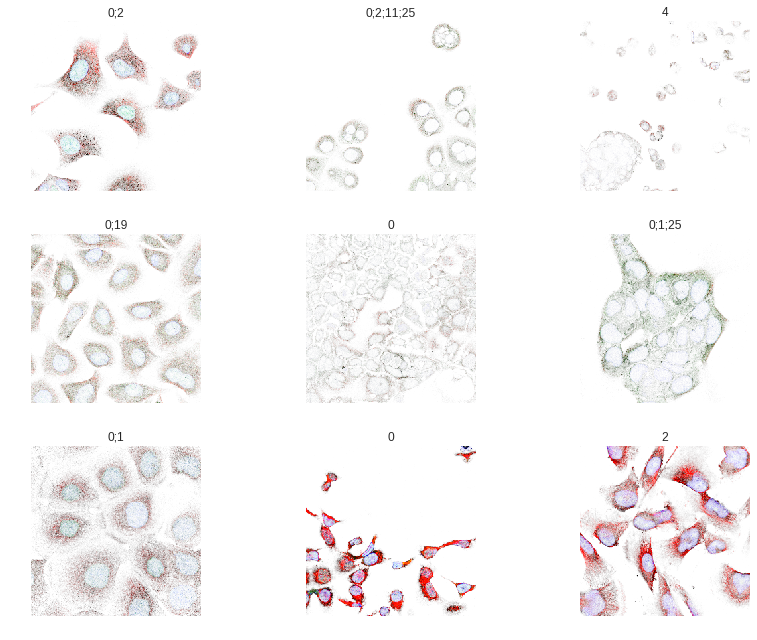

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [0]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=DATA_PATH,    
    metrics=[f1_score], 
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89582819.64it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


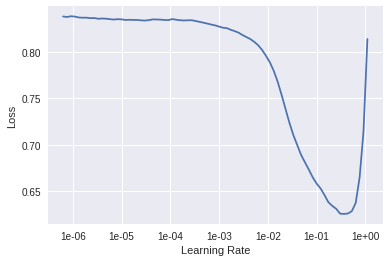

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-2

In [0]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.132520,0.123627,0.556527


In [0]:
learn.export(fname="../models/protein4c-stg-1-rn50v2.pkl")

In [0]:
! ls {MODEL_PATH}

models	protein4c-stg-1-rn50.pkl  protein4c-stg-1-rn50v2.pkl


In [0]:
!cp {MODEL_PATH}/protein4c-stg-1-rn50.pkl /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/protein4c-stg-1-rn50.pkl

In [0]:
#preds,_ = learn.get_preds(DatasetType.Test)

In [0]:
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
#df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
#df.to_csv({DATA_PATH}/'protein4c_predictions.csv', header=True, index=False)

In [0]:
#!cp {DATA_PATH}/protein4c_predictions.csv /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/protein4c_predictions.csv

In [0]:
def build_submission(learn_inference, fname) :
  sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')
  
  ids = list(sample_df.Id)

  out = open(DATA_PATH/fname, 'w')
  out.write('Id,Predicted\n')

  i = 0;
  n = 0;
  for id in ids:
    img = open_4_channel(TEST_PATH/id)
    preds = learn_inference.predict(img)
    l = str(preds[0]).replace(';', ' ')
    if l == '': n = n+1
    #print("{},{},{}".format(n, f, l ))
    out.write("{},{}\n".format(id, l )) 
    i = i + 1
    if i < 15 : print("{},{}\n".format(id, l ))

  out.close()

In [0]:
build_submission(learn, 'submission-stg-1-rn50.csv')

00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2

0000a892-bacf-11e8-b2b8-ac1f6b6435d0,

0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25

0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0

000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,

00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4

001765de-bacd-11e8-b2b8-ac1f6b6435d0,4 25

0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 25

00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0

0026f154-bac6-11e8-b2b7-ac1f6b6435d0,

002729d2-bace-11e8-b2b8-ac1f6b6435d0,25

002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0,5

003170fa-bacd-11e8-b2b8-ac1f6b6435d0,2 25

0031820a-baca-11e8-b2b8-ac1f6b6435d0,



In [0]:
!cp {DATA_PATH}/submission-stg-1-rn50.csv /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/submission-stg-1-rn50.csv

## Training stage 2

In [0]:
!cp /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/protein4c-stg-1-rn50.pkl {MODEL_PATH}/protein4c-stg-1-rn50.pkl

In [0]:
! ls {MODEL_PATH}

models	protein4c-stg-1-rn50.pkl  protein4c-stg-1-rn50v2.pkl


In [0]:
learn2 = load_learner(path=MODEL_PATH, fname="protein4c-stg-1-rn50v2.pkl")

In [0]:
learn2 = learn

In [0]:
learn2.unfreeze()

In [0]:
learn2.lr_find()

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(15, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.124650,0.120589,0.568679
2,0.121295,0.117593,0.577773
3,0.121971,0.116202,0.583629
4,0.118488,0.115080,0.597247
5,0.114794,0.112431,0.605769
6,0.113060,0.110135,0.610096
7,0.112522,0.108479,0.613221
8,0.108373,0.105898,0.629655
9,0.105608,0.105115,0.631918
10,0.105045,0.103663,0.637908


In [0]:
build_submission(learn2, 'submission-stg-2-rn50v2.csv')

00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2

0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5

0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25

0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0

000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,

00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4

001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25

0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 25

00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0

0026f154-bac6-11e8-b2b7-ac1f6b6435d0,25

002729d2-bace-11e8-b2b8-ac1f6b6435d0,25

002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0,

003170fa-bacd-11e8-b2b8-ac1f6b6435d0,25

0031820a-baca-11e8-b2b8-ac1f6b6435d0,



In [0]:
!cp {DATA_PATH}/submission-stg-2-rn50v2.csv /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/submission-stg-2-rn50v2.csv

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [0]:
! head {DATA_PATH}/train.csv

Id,Target
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0


In [0]:
df = pd.read_csv(DATA_PATH/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [0]:
print("Number of sample:", df.shape[0])

Number of sample: 31072


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
11703/31072

0.3766413491246138

In [0]:
src = (ImageItemList.from_csv(DATA_PATH, 'train.csv', folder='train', suffix='_green.png')
       .random_split_by_pct(0.38)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

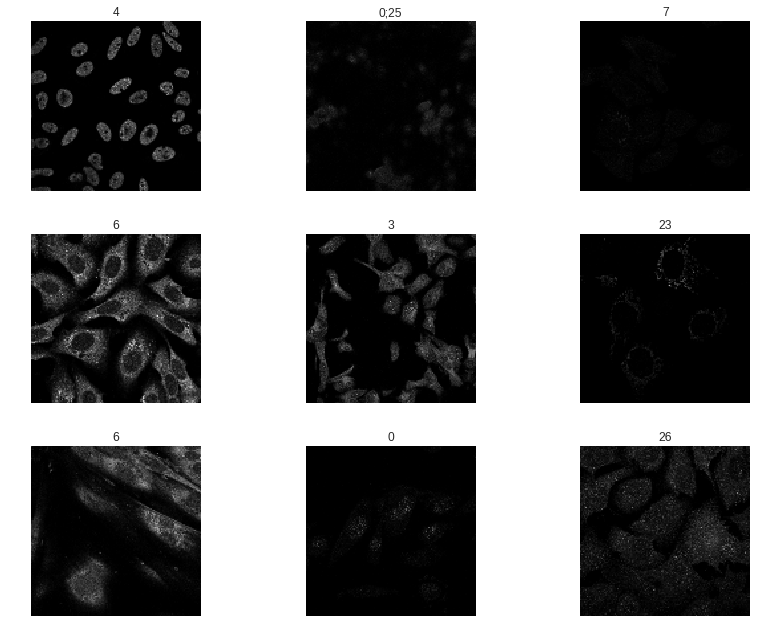

In [0]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta=1)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


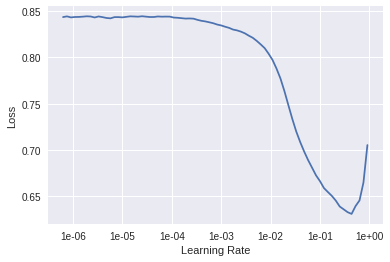

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.165499,0.150267,0.931738,0.453110
2,0.146120,0.137561,0.937555,0.502386
3,0.136965,0.131801,0.939340,0.530601
4,0.131468,0.126720,0.942562,0.549374
5,0.125986,0.125431,0.942837,0.555522


In [0]:
learn.export(fname="../models/protein-stg-1-rn50.pkl")

In [0]:
! ls {MODEL_PATH}

protein.pkl  protein-stg-1-rn50.pkl  stage-2-256-rn50.pth


In [0]:
results = learn.validate(dl=learn.data.valid_dl)
results

[0.121857055, tensor(0.9449), tensor(0.5730)]

In [0]:
TEST_PATH = DATA_PATH/'test'

In [0]:
def build_submission(learn_inference, fname) :
  sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')
  
  ids = list(sample_df.Id)

  out = open(DATA_PATH/fname, 'w')
  out.write('Id,Predicted\n')

  i = 0;
  n = 0;
  for id in ids:
    file_name = id + '_green.png'
    img = open_image(TEST_PATH/file_name)
    preds = learn_inference.predict(img)
    l = str(preds[0]).replace(';', ' ')
    if l == '': n = n+1
    #print("{},{},{}".format(n, f, l ))
    out.write("{},{}\n".format(id, l )) 
    i = i + 1
    if i < 15 : print("{},{}\n".format(id, l ))

  out.close()

In [0]:
build_submission(learn, 'submission-stg-1-rn50.csv')

00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2

0000a892-bacf-11e8-b2b8-ac1f6b6435d0,25

0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25

0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25

000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25

00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4

001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25

0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0

00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0

0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0

002729d2-bace-11e8-b2b8-ac1f6b6435d0,25

002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0,

003170fa-bacd-11e8-b2b8-ac1f6b6435d0,25

0031820a-baca-11e8-b2b8-ac1f6b6435d0,



...And fine-tune the whole model:

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


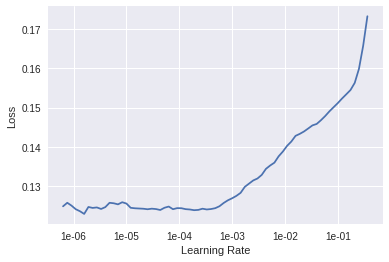

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.127105,0.123744,0.943400,0.607415
2,0.125275,0.119528,0.944831,0.628648
3,0.119612,0.115126,0.949411,0.637958
4,0.112894,0.110870,0.948337,0.659277
5,0.108006,0.108839,0.949952,0.666798


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


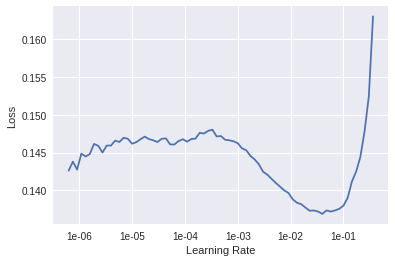

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.114246,0.108709,0.950613,0.665168
2,0.106286,0.103249,0.954297,0.683650
3,0.104130,0.100123,0.951308,0.705023
4,0.099774,0.097955,0.954670,0.708673
5,0.098549,0.097311,0.955670,0.710192


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.101055,0.101148,0.952049,0.698464
2,0.102540,0.099679,0.955308,0.701801
3,0.096110,0.094015,0.955297,0.721826
4,0.089088,0.090727,0.958234,0.733182
5,0.084608,0.089545,0.959010,0.739621


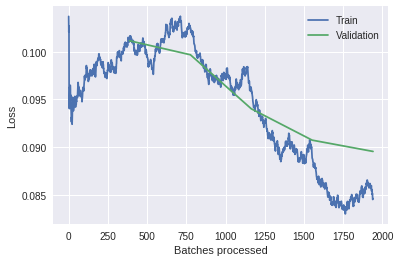

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## Save the model

In [0]:
! ls -l {path}/models

total 936672
-rw-r--r-- 1 root root 120250473 Feb  3 19:43 stage-1-256-rn50.pth
-rw-r--r-- 1 root root 120250481 Feb  3 18:25 stage-1-rn50.pth
-rw-r--r-- 1 root root 307906891 Feb  3 20:42 stage-2-256-rn50.pth
-rw-r--r-- 1 root root 307906883 Feb  3 18:55 stage-2-rn50.pth
-rw-r--r-- 1 root root 102823201 Feb  3 18:55 tmp.pth


Save the model to local disk...

In [0]:
from google.colab import files
files.download(path/'models/stage-2-256-rn50.pth')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp {path}/models/stage-2-256-rn50.pth /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/stage-2-256-rn50.pth

In [0]:
learn.load('stage-2-256-rn50')

In [0]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))